In [1]:
%load_ext autoreload
%autoreload 2

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from paths import RAW_DIR, STAGE_DIR
from display import cdisplay

In [12]:
data = pd.read_parquet(STAGE_DIR / 'process' / 'predictions.parquet')
data_univariate = pd.read_parquet(STAGE_DIR / 'process' / 'predictions_univariate.parquet')
data_multivariate = pd.read_parquet(STAGE_DIR / 'process' / 'predictions_multivariate.parquet')

In [18]:
TARGET = 'HeartDiseaseorAttack'
POST_TREATMENT_COST = 50000
PLAN_COST = 1000
REDUCTION_GOAL_PERCENTAGE = 0.8
ACCEPTANCE_PERCENTAGE = 0.85
RISK_REDUCTION_PERCENTAGE = 0.75

In [5]:
baseline_cost = data[data[TARGET].eq(1)].shape[0] * POST_TREATMENT_COST
goal_cost = baseline_cost * REDUCTION_GOAL_PERCENTAGE

# Basic cost analysis

The basic cost analysis strategy aims to know the plan's adherance percentage needed to achieve the 20% cost's reduction. The model output is used to select the most vulnerable population to be offer the plan and reducing also the heart attack risk in the population.

In [32]:
def cost_analysis(df, prob_column, target_column, reduction_goal, acceptance_percentage, pre_cost, post_cost, risk_reduction):
    # get amount of people
    population_amount = data[data[target_column].eq(1)].shape[0]
    print(f'{population_amount=}')
    # select population who will receive the offer
    offer_population = df.sort_values(prob_column, ascending=False) \
                         .iloc[:population_amount]
    # randomly select population who will accept the plan based on
    # 85% assumption
    accept_population = offer_population.sample(frac=acceptance_percentage)
    # get baseline cost to reduce with the plan
    baseline_cost = population_amount * post_cost
    print(f'{baseline_cost=}')
    # get reduced cost
    reduced_cost = baseline_cost * reduction_goal
    print(f'{reduced_cost=}')
    # amount of people that should adhere the plan in order to achieve the goal
    adherence_amount = (baseline_cost - reduced_cost) / (post_cost - pre_cost)
    print(f'{adherence_amount=}')
    # get percentage of adherance
    adherence_percentage = adherence_amount / accept_population.shape[0]
    print(f'{adherence_percentage=}')

    # adherance population
    adherence_population = accept_population.sample(frac=adherence_percentage)
    # mean vulnerable population's risk
    mean_baseline_risk = offer_population[prob_column].mean()
    print(f'{mean_baseline_risk=}')
    # readuce vulnerable population's risk
    mean_reduced_risk = np.where(
        offer_population.index.isin(adherence_population.index),
        offer_population[prob_column] * risk_reduction,
        offer_population[prob_column]
    ).mean()
    print(f'{mean_reduced_risk=}')
    return offer_population, adherence_percentage

In [80]:
def plot_risk_cost_reduction(df, prob_column, risk_reduction, base_adherance_percentage, post_cost, pre_cost):
    fig, ax = plt.subplots(2, 1, figsize=(6, 6), sharex=True)

    adherence_percentages = np.arange(base_adherance_percentage, 1.0, 0.1)
    print(f'{adherence_percentages=}')

    mean_risk_reductions = [
        np.where(
            df.index.isin(df.sample(frac=adherance_percentage).index),
            df[prob_column] * risk_reduction,
            df[prob_column]
        ).mean()
        for adherance_percentage in adherence_percentages
    ]
    print(f'{mean_risk_reductions=}')

    total_population = df.shape[0]
    cost_reductions = [
        total_population * post_cost - total_population * adherance_percentage * (post_cost - pre_cost)
        for adherance_percentage in adherence_percentages
    ]
    print(f'{cost_reductions=}')

    sns.lineplot(x=adherence_percentages * 100, y=mean_risk_reductions, ax=ax[0], markers=True)
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter())
    ax[0].set_ylabel('Mean Risk Reduction (probability)')

    sns.lineplot(x=adherence_percentages * 100, y=cost_reductions, ax=ax[1], markers=True)
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter())
    ax[1].set_ylabel('Cost Reduction (€)')

    fig.text(0.5, 0.04, 'Percentage of adherance', ha='center')
    fig.suptitle('Cost and risk analysis')

In [33]:
offer_population, adherance_percentage = cost_analysis(
    df=data,
    prob_column='proba',
    target_column=TARGET,
    reduction_goal=REDUCTION_GOAL_PERCENTAGE,
    acceptance_percentage=ACCEPTANCE_PERCENTAGE,
    pre_cost=PLAN_COST,
    post_cost=POST_TREATMENT_COST,
    risk_reduction=RISK_REDUCTION_PERCENTAGE
)

population_amount=23893
baseline_cost=1194650000
reduced_cost=955720000.0
adherence_amount=4876.122448979592
adherence_percentage=0.24009662952285155
mean_baseline_risk=0.5202128641045853
mean_reduced_risk=0.49389509854720093


adherence_percentages=array([0.24009663, 0.34009663, 0.44009663, 0.54009663, 0.64009663,
       0.74009663, 0.84009663, 0.94009663])
mean_risk_reductions=[0.4889968508444585, 0.47602205197065134, 0.4631891769038456, 0.44998571917691765, 0.43701808165063355, 0.4238713846502094, 0.41102085380857806, 0.397812004342834]
cost_reductions=[913555190.3097148, 796479490.3097148, 679403790.3097148, 562328090.3097148, 445252390.3097148, 328176690.30971456, 211100990.30971467, 94025290.3097148]


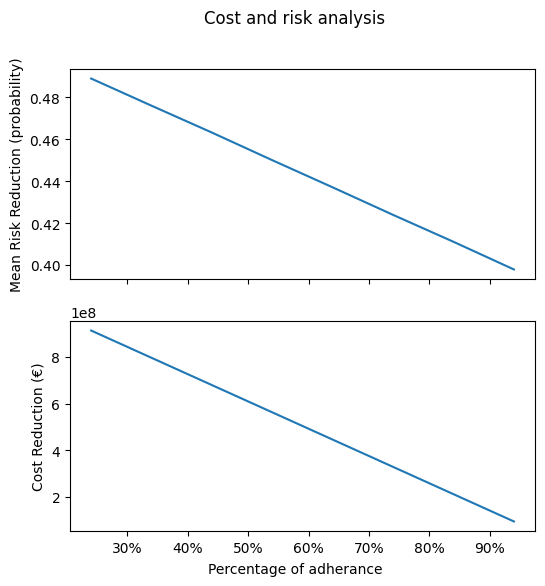

In [81]:
plot_risk_cost_reduction(
    df=offer_population,
    prob_column='proba',
    risk_reduction=RISK_REDUCTION_PERCENTAGE,
    base_adherance_percentage=adherance_percentage,
    post_cost=POST_TREATMENT_COST,
    pre_cost=PLAN_COST
)

# Complex cost analysis